In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import regex as re
from deep_translator import GoogleTranslator


In [2]:
import wikipediaapi
import nltk

def process_article(article_title,language,subpage):
    wiki = wikipediaapi.Wikipedia('FramingAnalysis (riedl.manuel.privat@gmail.com)', language,extract_format=wikipediaapi.ExtractFormat.WIKI)
    print(f"Processing: {article_title}\n" + f"\tlanguage:".ljust(20)+ language)
    page = wiki.page(article_title)
    article = page.text
    if language == "en":
        article = re.split(r'\nSee also\n', article)[0]
    if language == "de":
        print(f"\ttranslation:".ljust(20)+f"{language} - en")
        article = re.split(r'\nLiteratur\n', article)[0]
        sentences = nltk.tokenize.sent_tokenize(article)
        article = ""
        for sentence in sentences:
            translation = GoogleTranslator(source='de', target='en').translate(sentence)
            article +=str(translation)
    if subpage:
        links = page.links
        for title in sorted(links.keys()):
            print("%s: %s" % (title, links[title]))
                
    return article, page       
                

def get_articles(article_titles,language = "en",save = True,sub_pages = False):
    articles = []
    for article_title in article_titles:
        article, page = process_article(article_title,language,sub_pages)
        articles.append(article)
        if save:
            with open("articles/" + article_title+"_"+language+".txt", 'w',encoding="utf8") as file:
                file.write(article)
                print(f"\tsaved:".ljust(20)+f"{article_title}_{language}.txt")
    return articles         

        
        

In [3]:
from framefinder import framelabels

candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)

In [4]:
from framefinder import framedimensions

dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
base_model = 'all-mpnet-base-v2'
framing_dimensions = framedimensions.FramingDimensions(base_model, dimensions, pole_names)

In [5]:
import requests
import nltk
# nltk.download('punkt') # need to download punkt once

def read_files(filenames):
    files = []
    for file_name in filenames:
        with open("articles/" + file_name, 'r',encoding="utf8") as file:
            files.append(file.read())
    return files

def clean_string(text, remove_headers=True, remove_enumerations=True): # ? might not work for all articles, need to test
    text = re.split(r"==See also==", text)[0] # remove everything after "See also"
    text = re.sub(r'\{\{Asof\|(\d{4})\|(\d{1,2})\}\}', r'as of \2/\1', text) # replace {{Asof|YYYY|MM}} with as of MM/YYYY
    text = re.sub(r'\{\{.*}}', '', text) # remove {{}}
    text = re.sub(r'&lt;!--.*?-->', "", text) # remove <!--...-->  
    text = re.sub(r'&lt.*--',"", text) # remove &lt;!--
    text = re.sub(r'-->',"", text) # remove -->
    if remove_enumerations:
        text = re.sub(r'\n\*.*', '\n', text)
    else:
        text = re.sub(r'\n\* ', '\n', text) # remove enumeration symbol *
    text = re.sub(r'\n#', '\n', text) # remove enumeration symbol #
    text = re.sub(r'&lt;ref.*?&lt;/ref>', "", text) # remove <ref>...</ref>
    text = re.sub(r"&lt;ref.*/>", "", text) # remove <ref ... />
    if remove_headers:
        text = re.sub(r"==+.*==+\n", "", text) # remove lines containing ==, ===, ====, ...
    else:
        text = re.sub(r"==+", "", text) # remove ==, ===, ====, ...
    text = re.sub(r"'+", "", text) # remove ''', '''', ...
    text = re.sub(r'\xa0', ' ', text) # replace non-breaking space with space
    text = re.sub(r'\[\[File:(?:\[\[[^\]]*?\]\]|.)*?\]\]', "", text) # remove [[File:...]]
    text = re.sub(r'\[\[[^\|\]]*\|([^\]]+)\]\]', r'[[\1]]', text) # replace [[left|right]] with [right]
    text = text.replace(r"[[", "").replace("]]", "") # remove [[ and ]]
    text = re.sub(r'\{\|(?:(?:\{\|(?:(?:\{\|(?:[^{}])*\|\})|(?:[^{}]))*\|\})|(?:[^{}]))*\|\}',"",text)# replace nested {| * |}
    text = re.sub(r'\{\{(?:\n|.)*?\}\}',"",text) # replace {{ * }}
    text = re.sub(r'mini\|.*\|',"",text)
    text = re.sub(r'mini\|',"",text)
    text = re.sub(r':\* .*ISBN.*',"", text) # remove reverence books
    text = re.sub(r'Kategorie:.*',"", text) # remove reverence books
    text = re.sub(r'\n+', '\n', text) # replace multiple newlines with one

    
    return text

def extract_source(text):
    text = re.split(r'<textarea[^>]*>', text)[1]
    return re.split(r'</textarea>', text)[0]
    
def fetch_wiki_articles(articles,language="en"): # ? might not work for all articles, need to test
    article_texts = []
    for article in articles:
        response = requests.get(f"https://{language}.wikipedia.org/w/index.php?title={article}&action=edit")
        text = extract_source(response.text)
        article_texts.append(clean_string(text))
    return article_texts

def tokenize_articles(articles):
    tokenized_articles = []
    for article in articles:
        tokenized_articles.append(nltk.sent_tokenize(article))
    return tokenized_articles

def german_article(articles):
    translated_articles = []
    for article in articles:
        sentences = nltk.tokenize.sent_tokenize(article)
        text_en = ""
        for sentence in sentences:
            translation = GoogleTranslator(source='de', target='en').translate(sentence)
            text_en +=str(translation)
        translated_articles.append(text_en)
    return translated_articles   

def store_articles(articles, file_names):
    for i in range(len(articles)):
        with open("articles/" + file_names[i], 'w',encoding="utf8") as file:
            file.write(articles[i])


In [31]:
import os

def readDir(pathtodirectory, filestartswith = "",asone=True):
    file_contents = []
    count = 0
    if asone:
        file_contents.append("")
    try:
        for filename in os.listdir(pathtodirectory):
            if filename.startswith(filestartswith) or filestartswith == "":
                file_path = os.path.join(pathtodirectory, filename)
                with open(file_path, 'r',encoding="utf8") as file:
                    file_content = file.read()
                    if asone:
                        file_contents[0]+= file_content
                        count +=1
                        print(count)
                    else:
                        file_contents.append(file_content)
    except Exception as e:
        print("Dir not found", e)
    return file_contents

In [60]:
# fetch articles directly from wikipedia or use the ones in the articles folder
#article_titles = ["NS-Staat", "Sahara","Österreich"]
article_titles = ["Climate change","Climate change denial","Anti-abortion_movements", "Abortion-rights_movements"]

#articles = fetch_wiki_articles(article_titles,language="de")
# articles = [clean_string(article) for article in read_files(article_titles)]
#articles = german_article(articles)
#store_articles(articles, article_titles)
#articles = tokenize_articles(articles)
#get_articles(["Sahara"],language = "de")

#articles = get_articles(article_titles)
article_titles = ["IPCC-COP25_26"]
articles = readDir("data/Corpus-OIG (IGOs)/OIG_COP25_26","IPCC")
articles = tokenize_articles(articles)





1
2
3
4


In [61]:
for article in articles:
    print(article)

["\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSummary for Policymakers\nSummary for Policymakers\nIntroduction\nThis Report responds to the invitation for IPCC '... to provide a Special Report in 2018 on the impacts of global warming of 1.5°C above pre-industrial levels and related global greenhouse gas emission pathways' contained in the Decision of the 21st Conference of Parties of the United Nations Framework Convention on Climate Change to adopt the Paris Agreement.1\nThe IPCC accepted the invitation in April 2016, deciding to prepare this Special Report on the impacts of global warming of 1.5°C above pre-industrial levels and related global greenhouse gas emission pathways, in the context of strengthening the global response to the threat of climate change, sustainable development, and efforts to eradicate poverty.", 'This Summary for Policymakers (SPM) presents the key findings of the Special Report, based on the assessment of the ava

In [ ]:
for i in range(len(articles)):
    labels = framing_labels(articles[i])
    labels_df = pd.DataFrame(labels)
    _, ax = framing_labels.visualize(labels_df.mean().to_dict(), xerr=labels_df.sem())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.xticks([0.1, 0.5, 1])
    plt.title('Frame Labels for "' + article_titles[i] + '"')
    plt.axvline(0.5, color="red")
    plt.show()

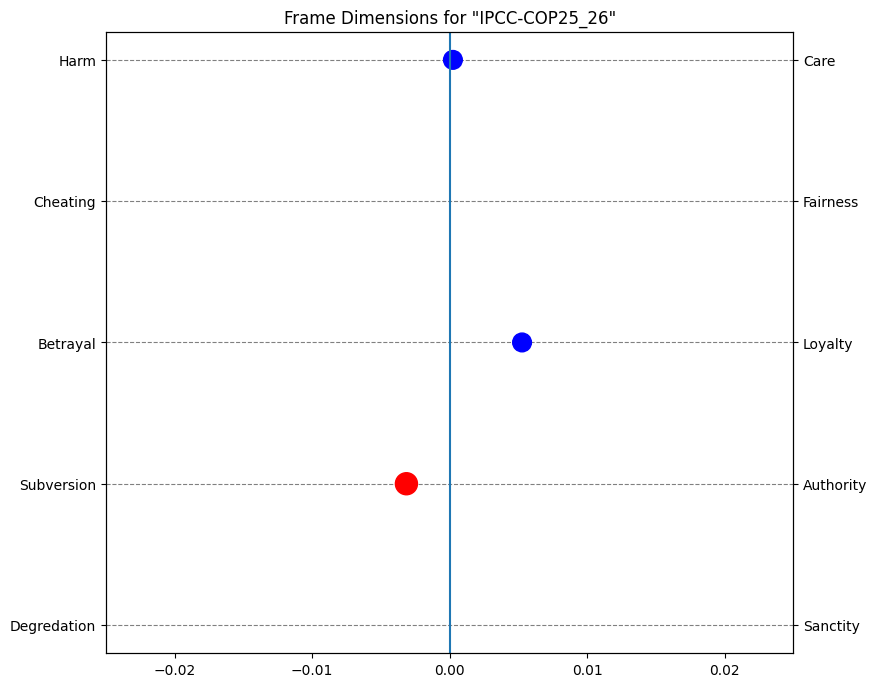

In [62]:
for i in range(len(articles)):
    dimensions = framing_dimensions(articles[i])
    dimensions_df = pd.DataFrame(dimensions)
    g = framing_dimensions.visualize(dimensions_df)
    g.axes[0].set_axisbelow(True)
    g.axes[0].yaxis.grid(color='gray', linestyle='dashed')
    plt.title('Frame Dimensions for "' + article_titles[i] + '"')
    plt.gcf().set_size_inches(10, 7)
    plt.xlim(-.025, .025)
    plt.savefig('plots/'+ article_titles[i])
    

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()